In [1]:
import warnings
warnings.filterwarnings('ignore')
# For ignoring warnings printed by R magic commands

In [2]:
import os
import glob

In [3]:
# Import pandas
import pandas as pd

In [4]:
# Load R magic
%load_ext rpy2.ipython
# Import ggplot2
%R require(ggplot2);

In [5]:
# If experiment parameters change, modify this function
def AddParametersAsColumns(df, folder):
    expParams = folder.split('/')[-1].split('.')
    
    cloudParams = expParams[1].split('_')
    df['groupSizeDist'] = cloudParams[10]
    df['placementDist'] = cloudParams[11]
    df['placementNumHostsPerLeaf'] = 'uniform' if cloudParams[12] == '-1' else cloudParams[12]
    df['seed'] = int(cloudParams[15])
    
    optimizerParams_0 = expParams[2].split('_')
    node_type_0 = optimizerParams_0[7]
    df['%sAlgorithm' % node_type_0] = optimizerParams_0[0]
    df['%sNumBitmaps' % node_type_0] = int(optimizerParams_0[1])
    df['%sNumNodesPerBitmap' % node_type_0] = int(optimizerParams_0[2])
    df['%sRedundancyPerBitmap' % node_type_0] = int(optimizerParams_0[3])
    df['%sNumRules' % node_type_0] = int(optimizerParams_0[4])
    
    if len(expParams) > 3:
        optimizerParams_1 = expParams[3].split('_')
        node_type_1 = optimizerParams_1[7]
        df['%sAlgorithm' % node_type_1] = optimizerParams_1[0]
        df['%sNumBitmaps' % node_type_1] = int(optimizerParams_1[1])
        df['%sNumNodesPerBitmap' % node_type_1] = int(optimizerParams_1[2])
        df['%sRedundancyPerBitmap' % node_type_1] = int(optimizerParams_1[3])
        df['%sNumRules' % node_type_1] = int(optimizerParams_1[4])
        
        dynamicParams = expParams[4].split('_')
        df['numEvents'] = int(dynamicParams[0])
    else:
        dynamicParams = expParams[3].split('_')
        df['numEvents'] = int(dynamicParams[0])
    
# Turns all files of a given filname across a set of folders into a single dataframe
def DataSetAsDataFrame(filename, folders, headers, header=None, reset_index=True):
    # Read dataset as dataframe
    def ReadDataSet(folder):
        df = pd.read_csv(folder + '/' + filename, sep=',', header=header, names=headers)
        AddParametersAsColumns(df, folder)
        return df
    # Get the list of dataframes
    dfs = map(ReadDataSet, folders)
    # Combine into a single dataframe
    df = pd.concat(dfs)
    if reset_index:
        df.reset_index(inplace=True)
        df.drop('index', axis=1, inplace=True)
    return df

In [6]:
%%R 
plotTheme <- theme(legend.title=element_blank(), legend.position="top", legend.text=element_text(size=6))

In [7]:
directory = '/mnt/sdb1/baseerat/numerical-evals/12-24-2017/logs-1M/'
# folders = glob.glob("logs*_0.*")
folders = glob.glob(directory + "dynamic-logs.*_0.*") + glob.glob(directory + "dynamic-logs.*_1.*")
# Note: dynamic-logs.*_2.* is corrupted. 
# Specifically, this run: pypy3 run_dynamic_with_data.py 1000000 /mnt/sdb1/baseerat/numerical-evals/12-24-2017/output-1M/optimizer.12_48_48_20_3000_10_5000_expon_1000000_5_wve_colocate-uniform_-1_True_5_2.random-fuzzy-match_2_3_6_64000_2_3_pods.exact-match_30_3_0_64000_2_3_leafs /mnt/sdb1/baseerat/numerical-evals/12-24-2017/logs-1M/dynamic-logs

In [ ]:
switchUpdateCount = DataSetAsDataFrame('switch_update_count.csv',
                                       folders, ['updates', 'switch', 'event'],
                                       header=0)

In [ ]:
switchUpdateCount.head(2)

In [ ]:
switchUpdateCount[
    (switchUpdateCount['switch'] == 'pod') & 
    (switchUpdateCount['event'] == 'join')
]['updates'].describe()

In [ ]:
switchUpdateCount[
    (switchUpdateCount['switch'] == 'pod') & 
    (switchUpdateCount['event'] == 'leave')
]['updates'].describe()

In [ ]:
%%R -i switchUpdateCount
ggplot(switchUpdateCount) +
   geom_boxplot(aes(y=updates, x=factor(event), 
                    fill=interaction(leafsAlgorithm, leafsNumBitmaps, leafsNumNodesPerBitmap, leafsRedundancyPerBitmap,
                                     leafsNumRules, placementNumHostsPerLeaf)),
                outlier.size=0.5) +
   facet_grid(groupSizeDist ~ factor(switch, levels=c('pod','leaf','virtual'))) +
   xlab("Event Type") +
   ylab("Number of updates") +
   plotTheme

In [13]:
# %%R -i switchUpdateCount
# ggplot(switchUpdateCount) +
#    stat_ecdf(aes(x=updates, col=interaction(leafsAlgorithm, leafsNumNodesPerBitmap, leafsRedundancyPerBitmap,
#                                      leafsNumRules, placementNumHostsPerLeaf))) +
#    facet_grid(groupSizeDist * leafsNumBitmaps ~ factor(switch, levels=c('pod','leaf','virtual')) * event) +
#    ggtitle("Event updates distribution") +
#    xlab("Number of updates") +
#    plotTheme

In [14]:
switchUpdateCount.to_csv(directory + 'switch_update_count.csv', index=False)

In [8]:
switchUpdateCountNormalized = DataSetAsDataFrame('switch_update_count_normalized.csv',
                                                 folders, ['updates', 'switch', 'event'],
                                                 header=0)

In [9]:
switchUpdateCountNormalized.head(2)

,updates,switch,event,groupSizeDist,placementDist,placementNumHostsPerLeaf,seed,podsAlgorithm,podsNumBitmaps,podsNumNodesPerBitmap,podsRedundancyPerBitmap,podsNumRules,leafsAlgorithm,leafsNumBitmaps,leafsNumNodesPerBitmap,leafsRedundancyPerBitmap,leafsNumRules,numEvents
0,0.000259,virtual,join,uniform,colocate-uniform,uniform,0,random-fuzzy-match,2,3,6,64000,exact-match,30,3,0,64000,1000000
1,0.503502,virtual,join,uniform,colocate-uniform,uniform,0,random-fuzzy-match,2,3,6,64000,exact-match,30,3,0,64000,1000000


In [10]:
switchUpdateCountNormalized[
    (switchUpdateCountNormalized['groupSizeDist'] == 'wve') &
    (switchUpdateCountNormalized['switch'] == 'virtual') &
    (switchUpdateCountNormalized['event'] == 'join') &
    (switchUpdateCountNormalized['updates'] > 1)
]

,updates,switch,event,groupSizeDist,placementDist,placementNumHostsPerLeaf,seed,podsAlgorithm,podsNumBitmaps,podsNumNodesPerBitmap,podsRedundancyPerBitmap,podsNumRules,leafsAlgorithm,leafsNumBitmaps,leafsNumNodesPerBitmap,leafsRedundancyPerBitmap,leafsNumRules,numEvents


In [11]:
switchUpdateCountNormalized[
    (switchUpdateCountNormalized['groupSizeDist'] == 'wve') &
    (switchUpdateCountNormalized['switch'] == 'virtual') &
    (switchUpdateCountNormalized['event'] == 'join')
]['updates'].describe()

count    1.412260e+06
mean     3.360687e-01
std      2.364679e-01
min      2.000400e-04
25%      6.493506e-03
50%      4.905030e-01
75%      5.061884e-01
max      7.611940e-01
Name: updates, dtype: float64

In [12]:
switchUpdateCountNormalized[
    (switchUpdateCountNormalized['groupSizeDist'] == 'wve') &
    (switchUpdateCountNormalized['switch'] == 'virtual') &
    (switchUpdateCountNormalized['event'] == 'leave')
]['updates'].describe()

count    1.441414e+06
mean     4.999598e-01
std      3.570731e-02
min      2.006421e-04
25%      4.891304e-01
50%      5.004182e-01
75%      5.118613e-01
max      7.727273e-01
Name: updates, dtype: float64

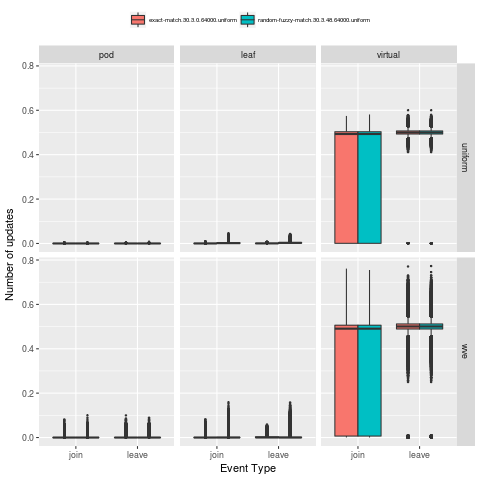

In [13]:
%%R -i switchUpdateCountNormalized
ggplot(switchUpdateCountNormalized) +
   geom_boxplot(aes(y=updates, x=factor(event), 
                    fill=interaction(leafsAlgorithm, leafsNumBitmaps, leafsNumNodesPerBitmap, leafsRedundancyPerBitmap,
                                     leafsNumRules, placementNumHostsPerLeaf)),
                outlier.size=0.5) +
   facet_grid(groupSizeDist ~ factor(switch, levels=c('pod','leaf','virtual'))) +
   xlab("Event Type") +
   ylab("Number of updates") +
   plotTheme

In [17]:
# %%R -i switchUpdateCountNormalized
# ggplot(switchUpdateCountNormalized) +
#    stat_ecdf(aes(x=updates, col=interaction(leafsAlgorithm, leafsNumNodesPerBitmap, leafsRedundancyPerBitmap,
#                                      leafsNumRules, placementNumHostsPerLeaf))) +
#    facet_grid(groupSizeDist * leafsNumBitmaps ~ factor(switch, levels=c('pod','leaf','virtual')) * event) +
#    ggtitle("Event updates distribution") +
#    xlab("Number of updates") +
#    plotTheme

In [14]:
switchUpdateCountNormalized.to_csv(directory + 'switch_update_count_normalized.csv', index=False)